**THIS NOTEBOOK CONTAINS SARIMAX MODEL TO FORECAST TRANSACTION AMOUNT FROM INVOICE DATA FOR SELLER ID 5 FOR COMING 6 MONTHS.**

In [81]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Below is importing the sells data and invoice data.**

In [82]:
sales=pd.read_csv("sales_receipt.csv")
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

**Below is importing the gdp data to use as exogenous data to make SARIMAX model for forecast.**

In [83]:
gdp=pd.read_csv("gdp.csv")
gdp=gdp.set_index("observation_date")

In [84]:
gdp.tail()

,GDP
observation_date,
2018-07-01,20749.752
2018-10-01,20897.804
2019-01-01,21098.827
2019-04-01,21337.898
2019-07-01,21340.000


**Below gdp data is used as exogenous data.**

In [85]:
gdp_tail=gdp.tail(43)

**Below is the sample of invoice data.**

In [86]:
invoice.head()

,TransactionDate,SellerId,Trans_amount
0,2019-03-15T00:00:00.000Z,19,10000
1,2017-04-18T00:00:00.000Z,19,5000000
2,2019-07-18T00:00:00.000Z,1,5000
3,2019-07-18T00:00:00.000Z,1,13000
4,2019-07-18T00:00:00.000Z,1,17500


**Below is the preparation of datetime format for forecasting.**

In [87]:
sales["TransactionDate"]=pd.to_datetime(pd.to_datetime(sales.TransactionDate).dt.date)
invoice["TransactionDate"]=pd.to_datetime(pd.to_datetime(invoice.TransactionDate).dt.date)

**Below is extracting columns that are needed.**

In [88]:
sales_fin=sales[["TransactionDate","SellerId", "Amount"]]
invoice_fin=invoice[["TransactionDate","SellerId","Trans_amount"]]

<font color="red">**SARIMAX ON INVOICE DATA FOR SELLER 5.**</font>

**Extracting SellerId 5 for further forecasting.**

In [89]:
data=invoice_fin[invoice_fin["SellerId"]==5][["TransactionDate","Trans_amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="M")).sum()

**Preparing gdp data.**

In [90]:
ind=data.index
value=gdp_tail.GDP.values
gdp_exgo=pd.DataFrame()
gdp_exgo["ObservationDate"]=ind
gdp_exgo["GDP"]=value

**Below plot shows the presence of seasonality of the transaction amount.**

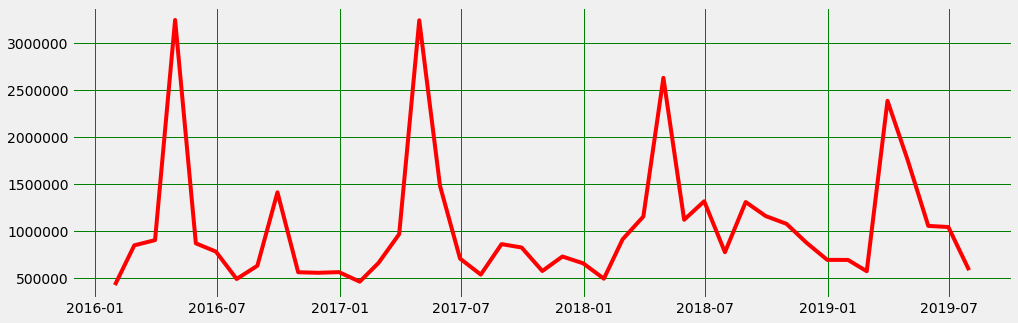

In [91]:
plt.figure(figsize=(15,5))
plt.plot(data.Trans_amount, color="red")
plt.grid(True, color="green")
plt.show()

**Below is function to test stationarity of the series.**

In [92]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

In [93]:
dft(data.Trans_amount)

Test_stats                     -4.158475
p-value                         0.000774
#Lags Used                      8.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

**This indicates that series is stationary.**

**Importing requisite libraries for running of model.**

In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random

**Below is preparing the exgogenous data(Using GDP DATA.) for training the model.**

In [95]:
data1=pd.DataFrame()
data1["TransactionDate"]=ind
data1["Amount"]=gdp_exgo.GDP.apply(lambda x: 100*x)
data1=data1.set_index("TransactionDate")

**Training the SARIMAX model by using data1 above as the exogenous data.**

In [96]:
model = SARIMAX(data.Trans_amount, exog=data1.Amount, order=(1, 0, 2), seasonal_order=(1,0,1,1))

**Fitting the model.**

In [97]:
model_fit = model.fit()

In [98]:
model_fit.aic

1280.9130440466913

In [99]:
model_fit.bic

1293.2414448565462

**Preparing the exogenous data for predicting the outcome.**

In [100]:
data2=pd.DataFrame()
data2["Trans_amount"] = gdp_exgo.GDP.tail(5).apply(lambda x:100*x)

**Predicting the amount using data2 above as exogenous data for the model.**

In [101]:
predict=model_fit.predict(start="2019-07-31", end="2019-12-31", exog=data2, dynamic=False)

**Below are the predicted values for the amount.**

In [102]:
predict

2019-07-31    1.205294e+06
2019-08-31    1.249338e+06
2019-09-30    1.434691e+06
2019-10-31    1.403910e+06
2019-11-30    1.351255e+06
2019-12-31    1.303957e+06
Freq: M, dtype: float64

**Preparing the dataframe of predicted values.**

In [103]:
def pred_fin(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

**Making the dataframe of predicted values by the model.**

In [104]:
pred_df=pd.DataFrame()
id=pd.date_range("2019-07-31","2019-12-31", freq="M")
pred_df["TransactionDate"]=id
pred_df["Trans_amount"]=predict.values
pred_df=pred_df.set_index("TransactionDate")

In [105]:
pred_df=pred_df.drop(pred_df.index[0])

**Below is function making the forecast continuous with the training set.**

In [106]:
data.tail()

,Trans_amount
TransactionDate,
2019-03-31,2381175
2019-04-30,1755100
2019-05-31,1051250
2019-06-30,1039225
2019-07-31,580450


In [107]:
pred_df.tail()

,Trans_amount
TransactionDate,
2019-08-31,1.249338e+06
2019-09-30,1.434691e+06
2019-10-31,1.403910e+06
2019-11-30,1.351255e+06
2019-12-31,1.303957e+06


In [108]:
pred_final=pred_fin(pred_df.Trans_amount, data.Trans_amount)

**following is the final forecast by the model.**

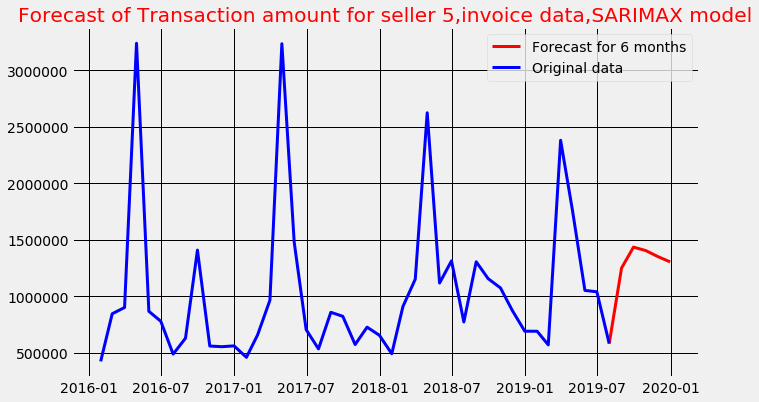

In [109]:
plt.figure(figsize=(10,6))
plt.plot(pred_final, color="red", linewidth=3, label="Forecast for 6 months")
plt.plot(data.Trans_amount, color="blue", linewidth=3, label="Original data")
plt.title("Forecast of Transaction amount for seller 5,invoice data,SARIMAX model", color="red")
plt.legend(loc="best")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="black")
plt.show()